In [59]:
import pandas as pd
import numpy as np

# ---------- helpers ----------
#CHANGE, AND SO SAMPLE USES 0.16, NOT 0.159
def nuts_filter(df):
    """
    Keep only articles that have at least one German NUTS code (starting with 'DE'),
    and collapse to one row per article id.
    """
    df = df.copy()
    
    df["NUTS"] = df["NUTS"].fillna("").astype(str)

    df_nuts_combined = (
        df.groupby("id").agg({
            "NUTS": lambda x: ", ".join(sorted({code for code in x if code.startswith("DE")})),
            "url": "first",
            "date": "first",
            "cos_dist": "first",
        })
        .reset_index()
    )

    df_nuts_combined = df_nuts_combined[df_nuts_combined["NUTS"] != ""].copy()

    return df_nuts_combined


def date_filter(df, start_year, end_year):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[
        (df["date"].dt.year >= start_year) &
        (df["date"].dt.year <= end_year)
    ].copy()


# ---------- main script ----------
#set source and output paths
source_path = '../../data/'
csv_output_path = '../../data/processed/'
figure_output_path = '../../doc/figures/'

file_path = "/Users/zoekirsman/Desktop/femicide_29-32/500000_32_homicide-female_DE.csv"
df = pd.read_csv(file_path)

print("Original rows:", len(df))

df = nuts_filter(df)
print("Rows after German NUTS filter:", len(df))

df = date_filter(df, 2017, 2023)
print("Rows after date filter (2017–2023):", len(df))

# ---------- diagnostics ----------

print("\nDiagnostics after filtering:")
print("  Unique IDs:", df["id"].nunique())
print("  Total rows:", len(df))
print("  Year range:", df["date"].dt.year.min(), "to", df["date"].dt.year.max())

print("\nSample NUTS values:")
print(df["NUTS"].head(10))

# --- Save unique filtered articles BEFORE sampling ---

filtered_out = "/Users/zoekirsman/Desktop/filtered_query32_articles.csv"
df.to_csv(filtered_out, index=False)
print("\nSaved filtered dataset to:", filtered_out)

# ---------- cosine bins & sampling ----------

min_cos = df["cos_dist"].min()
print("min cos", min_cos)
max_cos = df["cos_dist"].max()
print("max cos", max_cos)
bins = np.arange(0.16, max_cos + 0.02, 0.02)

df["cosine_bin"] = pd.cut(df["cos_dist"], bins=bins, include_lowest=True)

print("\nArticles per cosine bin:")
bin_counts = df["cosine_bin"].value_counts().sort_index()
print(bin_counts)

SAMPLES_PER_BIN = 150
samples = []
per_bin_taken = {}

for b in df["cosine_bin"].cat.categories:
    bin_df = df[df["cosine_bin"] == b]
    if len(bin_df) == 0:
        continue
    n = min(SAMPLES_PER_BIN, len(bin_df))
    per_bin_taken[str(b)] = n
    samples.append(bin_df.sample(n, random_state=42))

label_df = pd.concat(samples).reset_index(drop=True)

# ---------- sampling diagnostics ----------

print("\nSampling plan:")
for b in df["cosine_bin"].cat.categories:
    b_str = str(b)
    available = bin_counts.get(b, 0)
    taken = per_bin_taken.get(b_str, 0)
    print(f"  {b_str}: available={available}, taken={taken}")

print("\nTotal sampled:", len(label_df))

# ---------- output ----------

label_df = label_df[["id", "url", "NUTS", "cos_dist", "cosine_bin"]]

out_path = "/Users/zoekirsman/Desktop/samples_manual_tagging.csv"
label_df.to_csv(out_path, index=False)
print("\nSaved labeling CSV to:", out_path)

Original rows: 1143913
Rows after German NUTS filter: 375215
Rows after date filter (2017–2023): 364570

Diagnostics after filtering:
  Unique IDs: 364570
  Total rows: 364570
  Year range: 2017 to 2023

Sample NUTS values:
0            DEF08, DEF0E
1     DEA12, DEA1F, DEA34
2                   DE300
3     DE222, DE914, DEB1B
4            DEA47, DEA5B
5                   DE300
6            DE212, DEA22
8            DE261, DE264
9            DEB31, DEB3I
10    DE718, DE71E, DE721
Name: NUTS, dtype: object

Saved filtered dataset to: /Users/zoekirsman/Desktop/filtered_query32_articles.csv
min cos 0.16486917
max cos 0.2714406

Articles per cosine bin:
cosine_bin
(0.159, 0.18]        20
(0.18, 0.2]        2110
(0.2, 0.22]       19062
(0.22, 0.24]      57751
(0.24, 0.26]     135993
(0.26, 0.28]     149634
Name: count, dtype: int64

Sampling plan:
  (0.159, 0.18]: available=20, taken=20
  (0.18, 0.2]: available=2110, taken=150
  (0.2, 0.22]: available=19062, taken=150
  (0.22, 0.24]: availab

In [46]:
import pandas as pd

# load 
lab = pd.read_csv("/Users/zoekirsman/Desktop/manual_tagging-query32_checked_articles.csv")

# clean label column
lab["woman_murdered"] = (
    lab["woman_murdered"]
    .astype(str) 
    .str.strip() 
    .str.upper() 
)

# keep only TRUE/FALSE rows (drop unusable samples, i.e., rows where woman_murdered was left blank)
print("Total samples:", len(lab))
lab = lab[lab["woman_murdered"].isin(["TRUE", "FALSE"])]
lab["woman_murdered"] = (lab["woman_murdered"] == "TRUE").astype(int)
print("Number of usable samples:", len(lab))

# compute summary table
summary = lab.groupby("cosine_bin").agg(
    n=("woman_murdered", "count"),
    relevance_rate=("woman_murdered", "mean") # number of TRUE samples / total samples
)

summary.sort_index()



Total samples: 770
Number of usable samples: 677


,n,relevance_rate
cosine_bin,,
"(0.16, 0.18]",20,1.000000
"(0.18, 0.2]",136,0.992647
"(0.2, 0.22]",131,0.923664
"(0.22, 0.24]",130,0.753846
"(0.24, 0.26]",128,0.320312
"(0.26, 0.28]",132,0.136364


In [48]:
import numpy as np

# define narrower bin edges
edges = np.arange(0.16, 0.29, 0.01)  # 0.16, 0.17,..., 0.28

# add parameter that says what bin it belongs to
lab["cosine_bin2"] = pd.cut(
    lab["cos_dist"],
    bins=edges,
    right=True,     # (a, b]
)
# compute summary table
summary = lab.groupby("cosine_bin2", observed=True).agg(
    n=("woman_murdered", "count"),
    relevance_rate=("woman_murdered", "mean") # number of TRUE samples / total samples
)

summary.sort_index()

,n,relevance_rate
cosine_bin2,,
"(0.16, 0.17]",2,1.000000
"(0.17, 0.18]",18,1.000000
"(0.18, 0.19]",14,1.000000
"(0.19, 0.2]",122,0.991803
"(0.2, 0.21]",36,0.972222
"(0.21, 0.22]",95,0.905263
"(0.22, 0.23]",54,0.870370
"(0.23, 0.24]",76,0.671053
"(0.24, 0.25]",59,0.491525


In [52]:
# load full dataset
full = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

# define bin edges
edges = np.arange(0.16, 0.29, 0.02)  # 0.16, 0.18, 0.20, ..., 0.28

# add parameter for cosine bin
full["cosine_bin"] = pd.cut(
    full["cos_dist"],   
    bins=edges,
    right=True,
)

# sample stats
samples_stats = lab.groupby("cosine_bin", observed=True).agg(
    n=("woman_murdered", "count"),
    relevance_rate=("woman_murdered", "mean"),
)

# population stats
pop_stats = full.groupby("cosine_bin", observed=True).agg(
    n=("id", "count"),
)
pop_stats["relevance_estimate"] = samples_stats["relevance_rate"]

print(pop_stats)

# thresholds to evaluate
thresholds = [0.20, 0.21, 0.22, 0.225, 0.23, 0.24, 0.25, 0.26]

results = []

for t in thresholds:
    articles_included = full[full["cos_dist"] <= t] 
    n_articles_included = articles_included.shape[0]

    # weigthed sum: r1*c1 + r2*c2 + ... / c1 + c2 + ...
    counts_per_bin = articles_included.groupby("cosine_bin", observed=True).size()
    true_articles_included = (counts_per_bin[:-1] * pop_stats["relevance_estimate"][:-1]).sum()

    # compute last term of sum, where t <= edge of last bin
    # compute rate of subbin. if last bin is (x,y], then subbin is (x,t] where t<=y
    bin_of_t = counts_per_bin.index[-1]
    samples_included = lab[
        (lab["cos_dist"] <= t) &
        (lab["cosine_bin"] == bin_of_t)
    ]
    true_articles_included += samples_included["woman_murdered"].mean() * counts_per_bin.iloc[-1]
    relevance_estimate = true_articles_included / n_articles_included
    
    results.append({
        "threshold": t,
        "n_articles_included": n_articles_included,
        "relevance_estimate": relevance_estimate
    })

res_df = pd.DataFrame(results)
print("\nPrecision estimates (no CI yet):")
print(res_df)

# --------- weighted bootstrap for confidence intervals ---------
def bootstrap_weighted_ci(lab_df, full_df, thresholds, B=3000, random_state=42):
    rng = np.random.default_rng(random_state)
    boot_records = []

    # Group labeled data by bin to resample within bins
    grouped = {b: g for b, g in lab_df.groupby("bin")}

    for _ in range(B):
        # 1) build a bootstrap sample of labeled data, resampling within each bin
        boot_pieces = []
        for b, g in grouped.items():
            n = len(g)
            if n == 0:
                continue
            # sample row indices with replacement
            idx = rng.integers(0, n, size=n)
            boot_pieces.append(g.iloc[idx])

        boot_lab = pd.concat(boot_pieces, ignore_index=True)

        # 2) compute weighted precision for each threshold
        for t in thresholds:
            sub = boot_lab[boot_lab["cos_dist"] <= t]
            if len(sub) == 0:
                continue
            num = (sub["w"] * sub["wm"]).sum()
            den = sub["w"].sum()
            p = num / den
            boot_records.append({"threshold": t, "p": p})

    boot_df = pd.DataFrame(boot_records)
    ci = boot_df.groupby("threshold")["p"].quantile([0.025, 0.975]).unstack()
    ci.columns = ["ci_lower", "ci_upper"]
    return ci

ci_df = bootstrap_weighted_ci(lab, full, thresholds, B=2000)  # you can increase B if it's fast enough

# --------- combine estimates + CIs ---------
final = res_df.join(ci_df, on="threshold")

final = final.rename(columns={
    "p_hat_weighted": "precision_estimate",
    "pop_n_leq_t": "n_articles_included",
    "ci_lower": "ci_lower_95",
    "ci_upper": "ci_upper_95"
})

# Round relevant columns
final[["precision_estimate", "ci_lower_95", "ci_upper_95"]] = \
    final[["precision_estimate", "ci_lower_95", "ci_upper_95"]].round(4)

# Reset index to remove 0,1,2,... at left
final = final.reset_index(drop=True)

print("\nWeighted precision with 95% bootstrap CI:")
print(final.to_string(index=False))



                   n  relevance_estimate
cosine_bin                              
(0.16, 0.18]      20            1.000000
(0.18, 0.2]     2110            0.992647
(0.2, 0.22]    19062            0.923664
(0.22, 0.24]   57751            0.753846
(0.24, 0.26]  135993            0.320312
(0.26, 0.28]  149634            0.136364

Precision estimates (no CI yet):
   threshold  n_articles_included  relevance_estimate
0      0.200                 2130            0.992716
1      0.210                 7815            0.977808
2      0.220                21192            0.930605
3      0.225                31368            0.910803
4      0.230                44232            0.899229
5      0.240                78943            0.801296
6      0.250               132083            0.676668
7      0.260               214936            0.496971


KeyError: 'bin'

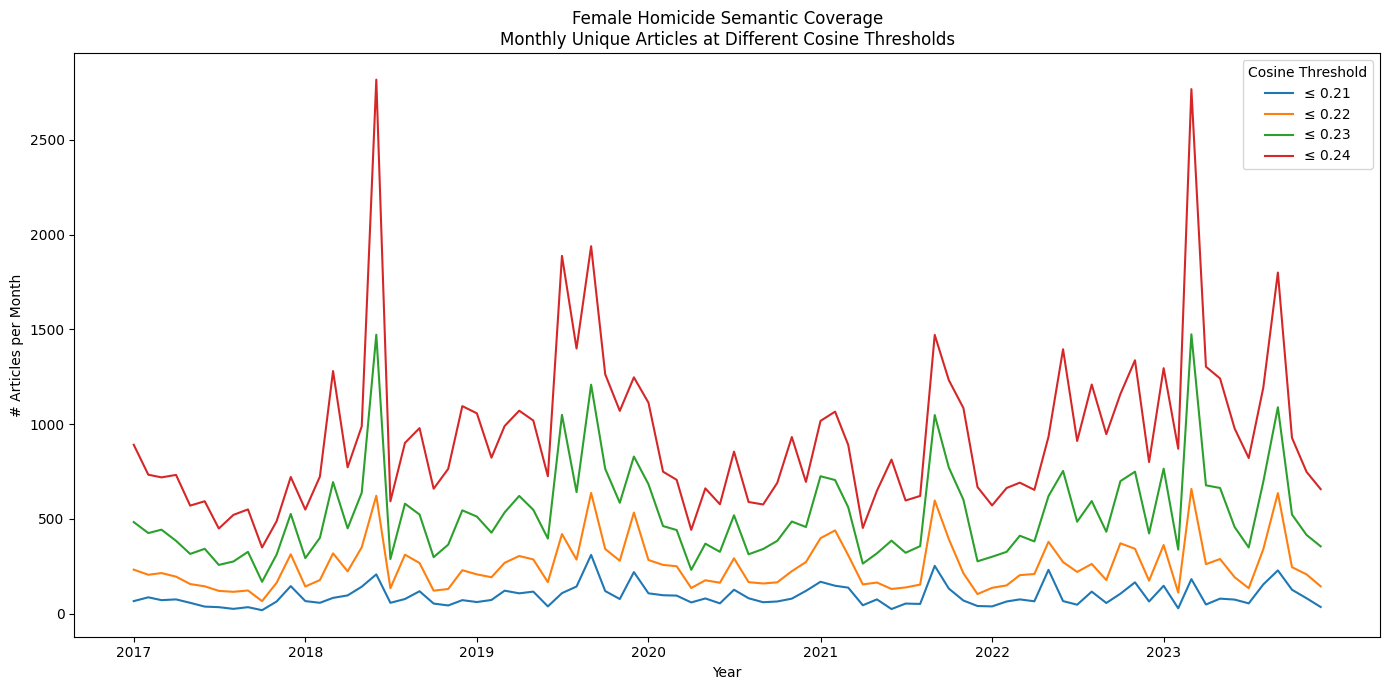

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"].notna()].drop_duplicates("id")
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

thresholds = [0.21, 0.22, 0.23, 0.24]

plt.figure(figsize=(14,7))

for t in thresholds:
    tmp = df[df["cos_dist"] <= t]
    monthly = tmp.groupby("month")["id"].nunique().sort_index()

    # reindex to continuous monthly index
    full = monthly.asfreq("MS")

    # interpolate for smoother curve (does not change peak heights)
    smooth = full.interpolate(method="linear")

    plt.plot(smooth.index, smooth.values, label=f"≤ {t}")

plt.title("Female Homicide Semantic Coverage\nMonthly Unique Articles at Different Cosine Thresholds")
plt.ylabel("# Articles per Month")
plt.xlabel("Year")

# show years on x axis
plt.xticks(
    [d for d in smooth.index if d.month == 1],
    [d.year for d in smooth.index if d.month == 1]
)

plt.legend(title="Cosine Threshold")
plt.tight_layout()
plt.savefig("/Users/zoekirsman/Desktop/monthly_threshold_interpolated.png")
plt.show()

In [101]:
import pandas as pd

import sys
print(sys.executable)

import plotly
import plotly.express as px

# Load filtered dataset (unique articles already)
df = pd.read_csv("/Users/zoekirsman/Desktop/filtered_query32_articles.csv")

# Parse date and keep valid
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"].notna()]

# Make sure it's unique per article id
df = df.drop_duplicates("id")

# Extract year-month
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

# thresholds to compare
thresholds = [0.21, 0.22, 0.23, 0.24]

rows = []

for t in thresholds:
    tmp = df[df["cos_dist"] <= t]
    monthly_counts = (
        tmp.groupby("month")["id"]
           .nunique()
           .sort_index()
    )
    
    for m, c in monthly_counts.items():
        rows.append({
            "month": m,
            "articles": c,
            "threshold": f"≤ {t}"
        })

plotdf = pd.DataFrame(rows)

# Make interactive line plot
fig = px.line(
    plotdf,
    x="month",
    y="articles",
    color="threshold",
    markers=True,
    title="Female Homicide Coverage — Monthly Unique Articles",
    labels={
        "month": "Month",
        "articles": "Unique articles per month",
        "threshold": "Cosine threshold"
    }
)

# Optional: nicer hover info
fig.update_traces(
    hovertemplate="Month: %{x|%Y-%m}<br>Articles: %{y}<br>Threshold: %{legendgroup}"
)

fig.show()

/Users/zoekirsman/femicide_env/bin/python


In [123]:
import numpy as np
import pandas as pd

# ---------- choose a precision requirement ----------
required_precision = 0.95   # change this to whatever you want (e.g. 0.92, 0.95, etc.)

# ---------- build a fine grid of thresholds ----------
# use the range of cosine distances present in your labeled data
t_min = lab["cos_dist"].min()
t_max = lab["cos_dist"].max()

# fine grid, step ~0.0005 (you can change the number of points if you like)
threshold_grid = np.linspace(t_min, t_max, num=500)

results = []

for t in threshold_grid:
    sub = lab[lab["cos_dist"] <= t]
    if len(sub) == 0:
        continue
    
    # weighted precision estimate at threshold t
    num = (sub["w"] * sub["wm"]).sum()
    den = sub["w"].sum()
    p_hat = num / den
    
    # how many articles in the FULL dataset are <= t?
    pop_n = full[full["cos_dist"] <= t]["id"].nunique()
    
    results.append({
        "threshold": t,
        "precision_estimate": p_hat,
        "n_articles_included": pop_n
    })

res = pd.DataFrame(results)

# ---------- pick the best threshold meeting the precision requirement ----------
valid = res[res["precision_estimate"] >= required_precision]

if len(valid) == 0:
    print(f"No threshold meets required precision ≥ {required_precision:.2f}")
else:
    # choose the LARGEST threshold that still satisfies the precision requirement
    chosen = valid.iloc[-1]
    
    thr = float(chosen["threshold"])
    prec = float(chosen["precision_estimate"])
    n_inc = int(chosen["n_articles_included"])
    
    print("\n=== Automatically chosen threshold ===")
    print(f"Required precision:        ≥ {required_precision:.3f}")
    print(f"Chosen threshold:           {thr:.5f}")
    print(f"Estimated precision:        {prec:.4f}")
    print(f"Articles included (full):   {n_inc}")
    
    # optional: show a small table of nearby thresholds for context
    vicinity = res.iloc[
        max(valid.index[-1]-5, 0) : valid.index[-1]+3
    ].copy()
    vicinity["precision_estimate"] = vicinity["precision_estimate"].round(4)
    print("\nThreshold vicinity:")
    print(vicinity.to_string(index=False))


=== Automatically chosen threshold ===
Required precision:        ≥ 0.950
Chosen threshold:           0.21847
Estimated precision:        0.9572
Articles included (full):   18541

Threshold vicinity:
 threshold  precision_estimate  n_articles_included
  0.217403              0.9625                16818
  0.217616              0.9625                17118
  0.217830              0.9631                17452
  0.218043              0.9635                17824
  0.218257              0.9644                18183
  0.218470              0.9572                18541
  0.218684              0.9433                18894
  0.218897              0.9438                19265
